In [4]:
import os
import pandas as pd
import numpy as np
import random
import umap
import umap.plot
from tqdm import tqdm
from gensim.models import Word2Vec 
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## 加载数据

In [5]:
def load_data(file_path):
    df = pd.read_table('../ml-1m/ratings.dat', sep='::', names = ['userID','itemID','Rating','Zip-code'])
    movies = pd.read_table('../ml-1m/movies.dat',sep='::',names=['MovieID','Title','Genres'],encoding='ISO-8859-1')
    movies['content'] = movies['Title'] + '__' + movies['Genres']

    # 所有userID
    users = df["userID"].unique().tolist()

    # 存储user的购买历史,每个user对应一个list,每个list当作一句话,所有list作为语料库
    corpus = []
    for i in tqdm(users):
        temp = df[df["userID"] == i]["itemID"].tolist()
        corpus.append(temp)

    # 建立商品字典,方便后续查看相似物品信息
    items_dict = movies.groupby('MovieID')['content'].apply(list).to_dict()

    return users, corpus, items_dict

In [3]:
users, corpus, items_dict = load_data('../ml-1m')

100%|██████████| 6040/6040 [00:03<00:00, 1712.48it/s]


## 训练 word2vec

In [6]:
# 训练word2vec模型
model = Word2Vec(window = 10, sg = 1, hs = 0, negative = 10, alpha=0.03, min_alpha=0.0007, seed = 14)
model.build_vocab(corpus, progress_per=200)
model.train(corpus, total_examples = model.corpus_count, epochs=10, report_delay=1)
# 模型训练完成, init_sims()提高内存运行效率
model.init_sims(replace=True)

## 查看模型相关参数

In [7]:
# 打印模型
print(model)

Word2Vec(vocab=3416, vector_size=100, alpha=0.03)


共有3416个item embedding,每个维度为100

## 查看相似物品信息

In [13]:
# 提取向量
X = model.wv[model.wv.key_to_index.keys()]

查看 movies 信息，这里我们就选第一个电影 "Toy Story"，看看它的相似电影

In [12]:
movies = pd.read_table('../ml-1m/movies.dat',sep='::',names=['MovieID','Title','Genres'],encoding='ISO-8859-1')
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


Toy Story 的 key 就是对应的 MovieID = 1，通过模型内置的字典找到它对应的索引为 29

In [14]:
model.wv.key_to_index[1]

29

计算并返回与它相似的10部电影

In [16]:
def similar_products(v, n = 10):
    """
    返回最相似的n个物品
    """
    # 为输入向量提取最相似的商品
    ms = model.wv.similar_by_vector(v, topn= n+1)[1:]
    # 提取相似产品的名称和相似度评分
    new_ms = []
    for j in ms:
        pair = (items_dict[j[0]][0], j[1])
        new_ms.append(pair)
    return new_ms   

for i in similar_products(X[29]):
    print(i[0])

Aladdin (1992)__Animation|Children's|Comedy|Musical
Silence of the Lambs, The (1991)__Drama|Thriller
Train of Life (Train De Vie) (1998)__Comedy|Drama
Home Alone (1990)__Children's|Comedy
Jumanji (1995)__Adventure|Children's|Fantasy
Waiting to Exhale (1995)__Comedy|Drama
Ghost (1990)__Comedy|Romance|Thriller
Beavis and Butt-head Do America (1996)__Animation|Comedy
Tom and Huck (1995)__Adventure|Children's
Brady Bunch Movie, The (1995)__Comedy


Toy Story 的类别是 Animation|Children's|Comedy ，与它相似的电影也大都是动画片、儿童电影，说明 word2vec 一定程度上的确给相似的电影学到了相似的embedding.

其中第2部 Silence of the Lambs , 现实中喜欢玩具总动员的大多是有冒险精神的大人，所以性格的另一面喜欢沉默的羔羊也是可以的（狡辩）


## 可视化物品和用户向量

In [23]:
# 两种画图方法
def visualize_emb(X):
    cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
    n_components=2, random_state=42).fit_transform(X)
    plt.figure(figsize=(10,9))
    plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')
    plt.show()


def umap_plot_emb(X):
    cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
    n_components=2, random_state=42).fit(X)
    umap.plot.points(cluster_embedding)

### 可视化物品向量

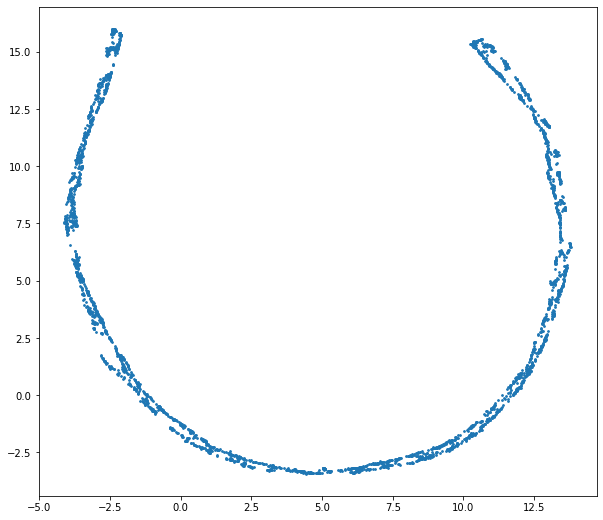

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


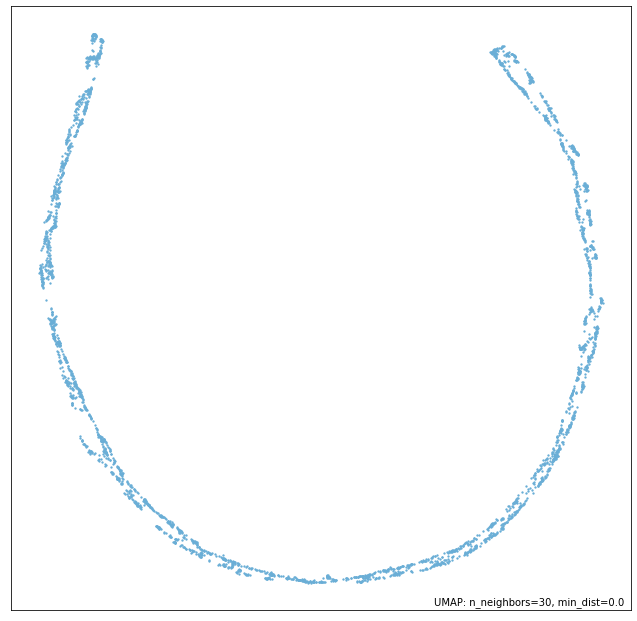

In [30]:
visualize_emb(X)
umap_plot_emb(X)

### 可视化用户向量

In [11]:
# 用户的向量可以用看过的电影的向量求均值，也可以对一部分求均值
def aggregate_vectors(products):
    """
    返回用户向量
    """
    product_vec = []
    for i in products:
        try:
            product_vec.append(model.wv[i])
        except KeyError:
            continue
        return np.mean(product_vec, axis=0)

In [12]:
usersVec_all_item = []  # 对看过的所有电影的向量求均值
usersVec_last_10 = []   # 对看过的最后10个电影的向量求均值
for i in range(len(users)):
    usersVec_all_item.append(aggregate_vectors(corpus[i]))
    usersVec_last_10.append(aggregate_vectors(corpus[i][-10:]))

#### 用所有看过的电影表示用户向量

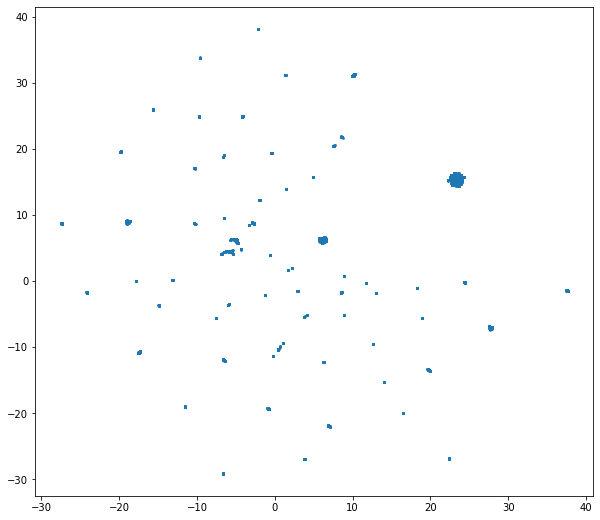

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


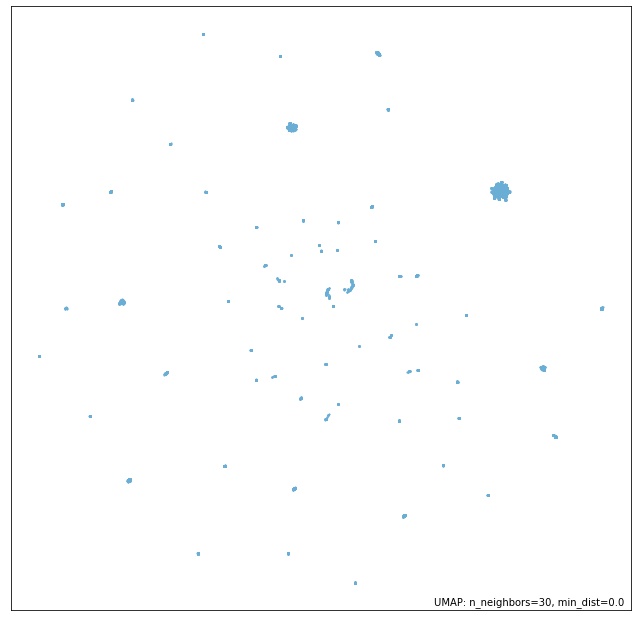

In [31]:
visualize_emb(usersVec_all_item)
umap_plot_emb(usersVec_all_item)

#### 用最后10部看过的电影表示用户向量

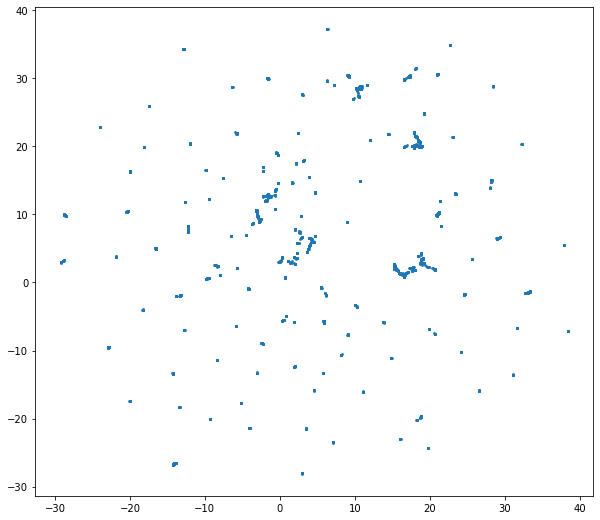

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


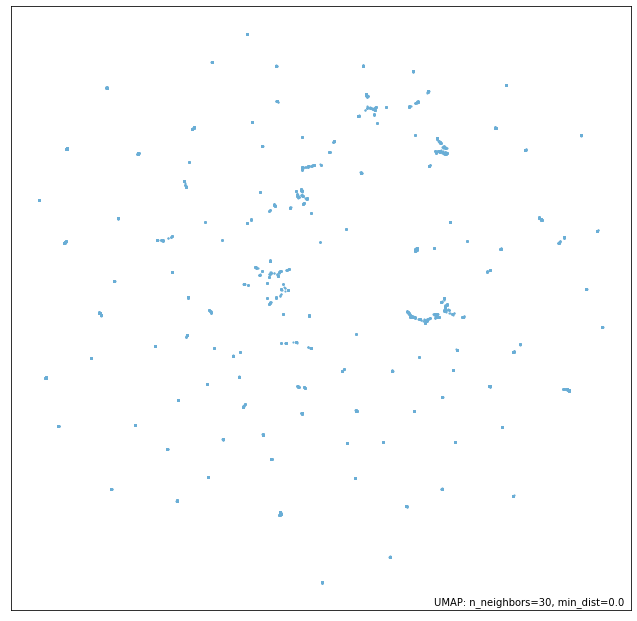

In [32]:
visualize_emb(usersVec_last_10)
umap_plot_emb(usersVec_last_10)